In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d/danofer/sarcasm/train-balanced-sarc.csv.gz
/kaggle/input/d/danofer/sarcasm/train-balanced-sarcasm.csv
/kaggle/input/d/danofer/sarcasm/test-balanced.csv
/kaggle/input/d/danofer/sarcasm/test-unbalanced.csv
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/sarcasm-detection/__results__.html
/kaggle/input/sarcasm-detection/__notebook__.ipynb
/kaggle/input/sarcasm-detection/__output__.json
/kaggle/input/sarcasm-detection/custom.css
/kaggle/input/sarcasm-detection/__results___files/__results___12_0.png
/kaggle/input/sarcasm-detection/__results___files/__results___15_1.png
/kaggle/input/sarcasm-detection/__results___files/__results___30_1.png
/kaggle/input/sarcasm-detection/__results___files/__results___30_0.png
/kaggle/input/sarcasm-detection/__results___files/__results___8_1.png
/kaggle/input/fake-news-detection-using-deep-neural-

In [9]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.1 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define BERT-based Sarcasm Detection Model
class BERTSarcasmDetector(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', dropout_rate=0.3):
        super(BERTSarcasmDetector, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Custom Dataset for Sarcasm data
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to train the BERT model
def train_bert_model(model, train_loader, val_loader, device, learning_rate=1e-5, epochs=15):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')
    
    return train_losses, train_accs, val_accs, model

# Function to make predictions with BERT
def predict_with_bert(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Plot metrics
def plot_metrics(train_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Sarcastic', 'Sarcastic'],
                yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# New function to load multiple datasets
def load_multiple_datasets(dataset_paths, sample_size_per_dataset=None):
    all_texts = []
    all_labels = []
    
    # Load Reddit dataset
    if 'train-balanced-sarcasm.csv' in dataset_paths:
        print(f"Loading Reddit Sarcasm dataset...")
        path = dataset_paths['train-balanced-sarcasm.csv']
        try:
            reddit_data = pd.read_csv(path, sep='\t')
            if len(reddit_data.columns) <= 1:
                reddit_data = pd.read_csv(path, sep=None, engine='python')
            
            reddit_data = reddit_data.dropna(subset=['comment'])
            if sample_size_per_dataset:
                reddit_data = reddit_data.sample(min(sample_size_per_dataset, len(reddit_data)), random_state=42)
            
            all_texts.extend(reddit_data['comment'].values)
            all_labels.extend(reddit_data['label'].values)
            print(f"Added {len(reddit_data)} samples from Reddit dataset")
        except Exception as e:
            print(f"Error loading Reddit dataset: {e}")
    
    # Load News Headlines dataset
    if 'Sarcasm_Headlines_Dataset.json' in dataset_paths:
        print(f"Loading News Headlines dataset...")
        path = dataset_paths['Sarcasm_Headlines_Dataset.json']
        try:
            # JSON file with each line being a separate JSON object
            headlines_data = []
            with open(path, 'r') as f:
                for line in f:
                    headlines_data.append(json.loads(line))
            
            headlines_df = pd.DataFrame(headlines_data)
            headlines_df = headlines_df.rename(columns={'is_sarcastic': 'label', 'headline': 'text'})
            
            if sample_size_per_dataset:
                headlines_df = headlines_df.sample(min(sample_size_per_dataset, len(headlines_df)), random_state=42)
            
            all_texts.extend(headlines_df['text'].values)
            all_labels.extend(headlines_df['label'].values)
            print(f"Added {len(headlines_df)} samples from Headlines dataset")
        except Exception as e:
            print(f"Error loading Headlines dataset: {e}")
    
    # Load Oraby et al. datasets (GEN, HYP, RQ)
    oraby_files = ['GEN-sarc-notsarc.csv', 'HYP-sarc-notsarc.csv', 'RQ-sarc-notsarc.csv']
    for file in oraby_files:
        if file in dataset_paths:
            print(f"Loading {file} dataset...")
            path = dataset_paths[file]
            try:
                oraby_data = pd.read_csv(path)
                
                # Convert 'class' to numeric labels (sarc=1, notsarc=0)
                label_map = {'sarc': 1, 'notsarc': 0}
                oraby_data['label'] = oraby_data['class'].map(label_map)
                
                if sample_size_per_dataset:
                    oraby_data = oraby_data.sample(min(sample_size_per_dataset, len(oraby_data)), random_state=42)
                
                all_texts.extend(oraby_data['text'].values)
                all_labels.extend(oraby_data['label'].values)
                print(f"Added {len(oraby_data)} samples from {file} dataset")
            except Exception as e:
                print(f"Error loading {file} dataset: {e}")
    
    print(f"Total combined dataset size: {len(all_texts)}")
    
    return np.array(all_texts), np.array(all_labels)

# Main workflow function with multiple datasets (BERT only)
def bert_sarcasm_detection(dataset_paths, epochs=15, batch_size=32, sample_size_per_dataset=2500):
    # 1. Load and preprocess data from multiple datasets
    print("Step 1: Loading and preprocessing data from multiple datasets...")
    
    try:
        all_texts, all_labels = load_multiple_datasets(dataset_paths, sample_size_per_dataset)
        
        # Split combined data into train, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(
            all_texts, all_labels, test_size=0.3, random_state=42, stratify=all_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Using sample data for demonstration")
        
        # Sample data for demonstration
        texts = [
            "I love waiting for hours at the DMV.",
            "This has been the best day ever!",
            "The weather is beautiful today.",
            "Sure, I'd love to work overtime on weekends.",
            "This phone has the best battery life I've ever seen.",
            "I couldn't be happier with this service.",
            "What a surprise, the train is late again.",
            "I'm so glad I spent all that money on this broken product.",
            "The customer service was excellent, very helpful.",
            "Absolutely fantastic, I waited 2 hours for this."
        ]
        labels = [1, 0, 0, 1, 0, 0, 1, 1, 0, 1]  # 1 for sarcastic, 0 for non-sarcastic
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=0.4, random_state=42, stratify=labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    # 2. Prepare BERT tokenizer and datasets
    print("Step 2: Preparing BERT tokenizer and datasets...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    train_dataset = SarcasmDataset(X_train, y_train, tokenizer)
    val_dataset = SarcasmDataset(X_val, y_val, tokenizer)
    test_dataset = SarcasmDataset(X_test, y_test, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 3. Initialize and train BERT model
    print("Step 3: Initializing and training BERT model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    bert_model = BERTSarcasmDetector()
    bert_model.to(device)
    
    train_losses, train_accs, val_accs, trained_model = train_bert_model(
        bert_model, train_loader, val_loader, device, epochs=epochs
    )
    
    # 4. Make predictions with BERT on test set
    print("Step 4: Making predictions with BERT...")
    bert_preds, true_labels = predict_with_bert(trained_model, test_loader, device)
    
    # Calculate metrics for BERT
    bert_accuracy = accuracy_score(true_labels, bert_preds)
    bert_precision = precision_score(true_labels, bert_preds, average='weighted')
    bert_recall = recall_score(true_labels, bert_preds, average='weighted')
    bert_f1 = f1_score(true_labels, bert_preds, average='weighted')
    
    print("\nBERT Model Metrics:")
    print(f"Accuracy: {bert_accuracy:.4f}")
    print(f"Precision: {bert_precision:.4f}")
    print(f"Recall: {bert_recall:.4f}")
    print(f"F1 Score: {bert_f1:.4f}")
    
    # Plot metrics for BERT
    plot_metrics(train_losses, train_accs, val_accs)
    plot_confusion_matrix(true_labels, bert_preds, "BERT Model Confusion Matrix")
    
    print("\nBERT Sarcasm Detection Workflow Completed!")
    
    return {
        'bert_model': trained_model,
        'tokenizer': tokenizer,
        'device': device,
        'bert_metrics': {
            'accuracy': bert_accuracy,
            'precision': bert_precision,
            'recall': bert_recall,
            'f1': bert_f1
        }
    }

# Function to use the trained model for prediction
def predict_sarcasm(text, model, tokenizer, device):
    # Preprocess text
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get BERT prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        bert_pred = torch.argmax(probs, dim=1).item()
        bert_prob = probs[0][bert_pred].item()
    
    result = "Sarcastic" if bert_pred == 1 else "Non-sarcastic"
    
    return {
        "prediction": result, 
        "confidence": bert_prob,
        "method": "BERT"
    }

# Example of how to use the code with multiple datasets
if __name__ == "__main__":
    # Paths to your dataset files
    dataset_paths = {
        'train-balanced-sarcasm.csv': '/kaggle/input/d/danofer/sarcasm/train-balanced-sarcasm.csv',
        'Sarcasm_Headlines_Dataset.json': '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json',
        'GEN-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/GEN-sarc-notsarc.csv',
        'HYP-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/HYP-sarc-notsarc.csv',
        'RQ-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/RQ-sarc-notsarc.csv'
    }
    
    # Run the BERT-only workflow with multiple datasets
    # Increased epochs from 3 to 15
    results = bert_sarcasm_detection(
        dataset_paths=dataset_paths,
        epochs=7,                   # Increased number of epochs
        batch_size=16,              # Adjust batch size based on your GPU memory
        sample_size_per_dataset=25000  # Use 2500 samples per dataset for balanced training
    )
    
    # After training, you can use the model to make predictions
    model = results['bert_model']
    tokenizer = results['tokenizer']
    device = results['device']
    
    sample_texts = [
        "I just love waiting in long lines at the grocery store.",
        "This movie was actually really good, I enjoyed it a lot.",
        "Oh great, another meeting that could have been an email.",
        "The weather today is beautiful and sunny.",
        "Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.",
        "I'm thrilled that my flight was delayed by 5 hours.",
        "Nothing brightens my day like stepping in a puddle with new shoes.",
        "Breaking news: Man realizes he forgot his phone after reaching office, world continues to exist."
    ]
    
    print("\nSample Predictions:")
    for text in sample_texts:
        result = predict_sarcasm(text, model, tokenizer, device)
        print(f"Text: '{text}'")
        print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
        print("-" * 50)

Step 1: Loading and preprocessing data from multiple datasets...
Loading Reddit Sarcasm dataset...
Added 25000 samples from Reddit dataset
Loading News Headlines dataset...
Added 25000 samples from Headlines dataset
Loading GEN-sarc-notsarc.csv dataset...
Added 6520 samples from GEN-sarc-notsarc.csv dataset
Loading HYP-sarc-notsarc.csv dataset...
Added 1164 samples from HYP-sarc-notsarc.csv dataset
Loading RQ-sarc-notsarc.csv dataset...
Added 1702 samples from RQ-sarc-notsarc.csv dataset
Total combined dataset size: 59386
Training set size: 41570
Validation set size: 8908
Test set size: 8908
Step 2: Preparing BERT tokenizer and datasets...
Step 3: Initializing and training BERT model...
Using device: cuda


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of available GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Step 1: Loading and preprocessing data from multiple datasets...
Loading Reddit Sarcasm dataset...
Added 15000 samples from Reddit dataset
Loading News Headlines dataset...
Added 15000 samples from Headlines dataset
Loading GEN-sarc-notsarc.csv dataset...
Added 6520 samples from GEN-sarc-notsarc.csv dataset
Loading HYP-sarc-notsarc.csv dataset...
Added 1164 samples from HYP-sarc-notsarc.csv dataset
Loading RQ-sarc-notsarc.csv dataset...
Added 1702 samples from RQ-sarc-notsarc.csv dataset
Total combined dataset size: 39386
Training set size: 27570
Validation set size: 5908
Test set size: 5908
Step 2: Preparing BERT tokenizer and datasets...
Step 3: Initializing and training BERT model with multi-GPU support...
Using device: cuda
Using 2 GPUs for training
Epoch 1/7 | Loss: 0.5431 | Train Acc: 0.7144 | Val Acc: 0.7801
Epoch 2/7 | Loss: 0.4077 | Train Acc: 0.8105 | Val Acc: 0.7976
Epoch 3/7 | Loss: 0.3054 | Train Acc: 0.8665 | Val

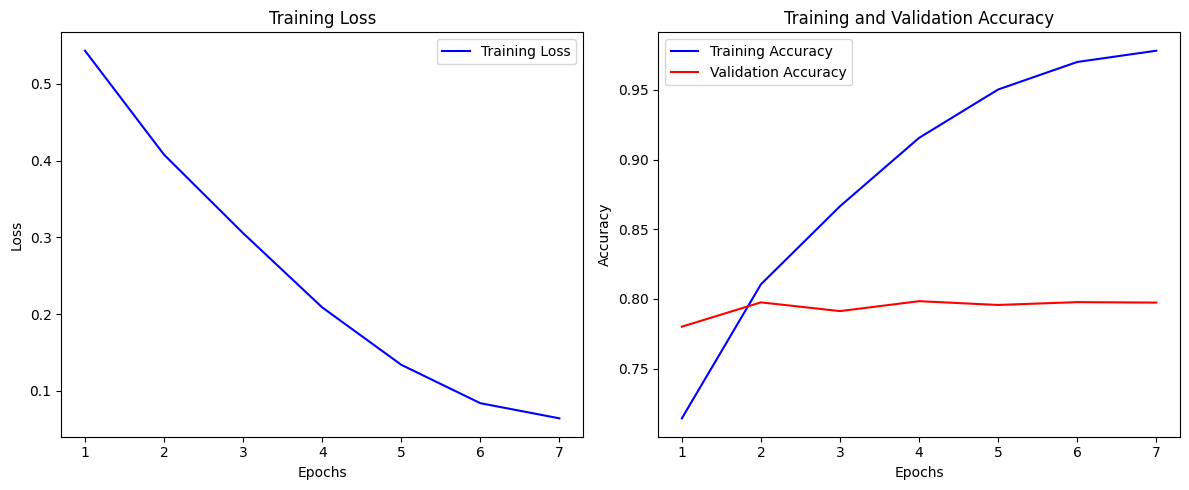

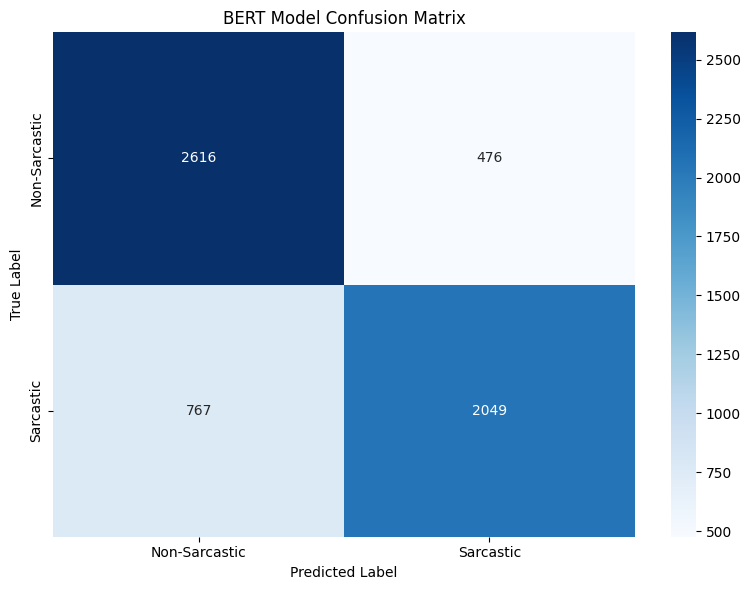


BERT Sarcasm Detection Workflow Completed!

Sample Predictions:
Text: 'I just love waiting in long lines at the grocery store.'
Prediction: Sarcastic (Confidence: 0.9704)
--------------------------------------------------
Text: 'This movie was actually really good, I enjoyed it a lot.'
Prediction: Non-sarcastic (Confidence: 0.9996)
--------------------------------------------------
Text: 'Oh great, another meeting that could have been an email.'
Prediction: Sarcastic (Confidence: 0.9675)
--------------------------------------------------
Text: 'The weather today is beautiful and sunny.'
Prediction: Non-sarcastic (Confidence: 0.9941)
--------------------------------------------------
Text: 'Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.'
Prediction: Non-sarcastic (Confidence: 0.9330)
--------------------------------------------------
Text: 'I'm thrilled that my flight was delayed by 5 hours.'
Prediction: Sarcastic (Confidence: 0.8891)
-----

In [11]:
import pandas as pd
import numpy as np
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Define BERT-based Sarcasm Detection Model
class BERTSarcasmDetector(nn.Module):
    def __init__(self, bert_model='bert-base-uncased', dropout_rate=0.3):
        super(BERTSarcasmDetector, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Custom Dataset for Sarcasm data
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to train the BERT model - modified for multi-GPU training
def train_bert_model(model, train_loader, val_loader, device, learning_rate=1e-5, epochs=15):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')
    
    return train_losses, train_accs, val_accs, model

# Function to make predictions with BERT
def predict_with_bert(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Plot metrics
def plot_metrics(train_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Sarcastic', 'Sarcastic'],
                yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# New function to load multiple datasets
def load_multiple_datasets(dataset_paths, sample_size_per_dataset=None):
    all_texts = []
    all_labels = []
    
    # Load Reddit dataset
    if 'train-balanced-sarcasm.csv' in dataset_paths:
        print(f"Loading Reddit Sarcasm dataset...")
        path = dataset_paths['train-balanced-sarcasm.csv']
        try:
            reddit_data = pd.read_csv(path, sep='\t')
            if len(reddit_data.columns) <= 1:
                reddit_data = pd.read_csv(path, sep=None, engine='python')
            
            reddit_data = reddit_data.dropna(subset=['comment'])
            if sample_size_per_dataset:
                reddit_data = reddit_data.sample(min(sample_size_per_dataset, len(reddit_data)), random_state=42)
            
            all_texts.extend(reddit_data['comment'].values)
            all_labels.extend(reddit_data['label'].values)
            print(f"Added {len(reddit_data)} samples from Reddit dataset")
        except Exception as e:
            print(f"Error loading Reddit dataset: {e}")
    
    # Load News Headlines dataset
    if 'Sarcasm_Headlines_Dataset.json' in dataset_paths:
        print(f"Loading News Headlines dataset...")
        path = dataset_paths['Sarcasm_Headlines_Dataset.json']
        try:
            # JSON file with each line being a separate JSON object
            headlines_data = []
            with open(path, 'r') as f:
                for line in f:
                    headlines_data.append(json.loads(line))
            
            headlines_df = pd.DataFrame(headlines_data)
            headlines_df = headlines_df.rename(columns={'is_sarcastic': 'label', 'headline': 'text'})
            
            if sample_size_per_dataset:
                headlines_df = headlines_df.sample(min(sample_size_per_dataset, len(headlines_df)), random_state=42)
            
            all_texts.extend(headlines_df['text'].values)
            all_labels.extend(headlines_df['label'].values)
            print(f"Added {len(headlines_df)} samples from Headlines dataset")
        except Exception as e:
            print(f"Error loading Headlines dataset: {e}")
    
    # Load Oraby et al. datasets (GEN, HYP, RQ)
    oraby_files = ['GEN-sarc-notsarc.csv', 'HYP-sarc-notsarc.csv', 'RQ-sarc-notsarc.csv']
    for file in oraby_files:
        if file in dataset_paths:
            print(f"Loading {file} dataset...")
            path = dataset_paths[file]
            try:
                oraby_data = pd.read_csv(path)
                
                # Convert 'class' to numeric labels (sarc=1, notsarc=0)
                label_map = {'sarc': 1, 'notsarc': 0}
                oraby_data['label'] = oraby_data['class'].map(label_map)
                
                if sample_size_per_dataset:
                    oraby_data = oraby_data.sample(min(sample_size_per_dataset, len(oraby_data)), random_state=42)
                
                all_texts.extend(oraby_data['text'].values)
                all_labels.extend(oraby_data['label'].values)
                print(f"Added {len(oraby_data)} samples from {file} dataset")
            except Exception as e:
                print(f"Error loading {file} dataset: {e}")
    
    print(f"Total combined dataset size: {len(all_texts)}")
    
    return np.array(all_texts), np.array(all_labels)

# Modified main workflow function for multi-GPU support
def bert_sarcasm_detection(dataset_paths, epochs=15, batch_size=32, sample_size_per_dataset=2500):
    # 1. Load and preprocess data from multiple datasets
    print("Step 1: Loading and preprocessing data from multiple datasets...")
    
    try:
        all_texts, all_labels = load_multiple_datasets(dataset_paths, sample_size_per_dataset)
        
        # Split combined data into train, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(
            all_texts, all_labels, test_size=0.3, random_state=42, stratify=all_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Using sample data for demonstration")
        
        # Sample data for demonstration
        texts = [
            "I love waiting for hours at the DMV.",
            "This has been the best day ever!",
            "The weather is beautiful today.",
            "Sure, I'd love to work overtime on weekends.",
            "This phone has the best battery life I've ever seen.",
            "I couldn't be happier with this service.",
            "What a surprise, the train is late again.",
            "I'm so glad I spent all that money on this broken product.",
            "The customer service was excellent, very helpful.",
            "Absolutely fantastic, I waited 2 hours for this."
        ]
        labels = [1, 0, 0, 1, 0, 0, 1, 1, 0, 1]  # 1 for sarcastic, 0 for non-sarcastic
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=0.4, random_state=42, stratify=labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    # 2. Prepare BERT tokenizer and datasets
    print("Step 2: Preparing BERT tokenizer and datasets...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    train_dataset = SarcasmDataset(X_train, y_train, tokenizer)
    val_dataset = SarcasmDataset(X_val, y_val, tokenizer)
    test_dataset = SarcasmDataset(X_test, y_test, tokenizer)
    
    # Increase batch size to better utilize multiple GPUs
    # With 2 GPUs, we can effectively double the batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # 3. Initialize and train BERT model with multi-GPU support
    print("Step 3: Initializing and training BERT model with multi-GPU support...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    bert_model = BERTSarcasmDetector()
    
    # Use DataParallel to utilize multiple GPUs
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training")
        bert_model = nn.DataParallel(bert_model)
        
    bert_model.to(device)
    
    train_losses, train_accs, val_accs, trained_model = train_bert_model(
        bert_model, train_loader, val_loader, device, epochs=epochs
    )
    
    # 4. Make predictions with BERT on test set
    print("Step 4: Making predictions with BERT...")
    bert_preds, true_labels = predict_with_bert(trained_model, test_loader, device)
    
    # Calculate metrics for BERT
    bert_accuracy = accuracy_score(true_labels, bert_preds)
    bert_precision = precision_score(true_labels, bert_preds, average='weighted')
    bert_recall = recall_score(true_labels, bert_preds, average='weighted')
    bert_f1 = f1_score(true_labels, bert_preds, average='weighted')
    
    print("\nBERT Model Metrics:")
    print(f"Accuracy: {bert_accuracy:.4f}")
    print(f"Precision: {bert_precision:.4f}")
    print(f"Recall: {bert_recall:.4f}")
    print(f"F1 Score: {bert_f1:.4f}")
    
    # Plot metrics for BERT
    plot_metrics(train_losses, train_accs, val_accs)
    plot_confusion_matrix(true_labels, bert_preds, "BERT Model Confusion Matrix")
    
    print("\nBERT Sarcasm Detection Workflow Completed!")
    
    return {
        'bert_model': trained_model,
        'tokenizer': tokenizer,
        'device': device,
        'bert_metrics': {
            'accuracy': bert_accuracy,
            'precision': bert_precision,
            'recall': bert_recall,
            'f1': bert_f1
        }
    }

# Function to use the trained model for prediction
def predict_sarcasm(text, model, tokenizer, device):
    # Preprocess text
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get BERT prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        bert_pred = torch.argmax(probs, dim=1).item()
        bert_prob = probs[0][bert_pred].item()
    
    result = "Sarcastic" if bert_pred == 1 else "Non-sarcastic"
    
    return {
        "prediction": result, 
        "confidence": bert_prob,
        "method": "BERT"
    }

# Example of how to use the code with multiple datasets
if __name__ == "__main__":
    # Paths to your dataset files
    dataset_paths = {
        'train-balanced-sarcasm.csv': '/kaggle/input/d/danofer/sarcasm/train-balanced-sarcasm.csv',
        'Sarcasm_Headlines_Dataset.json': '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json',
        'GEN-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/GEN-sarc-notsarc.csv',
        'HYP-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/HYP-sarc-notsarc.csv',
        'RQ-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/RQ-sarc-notsarc.csv'
    }
    
    # Run the BERT-only workflow with multiple datasets
    # Adjusted for multi-GPU training
    results = bert_sarcasm_detection(
        dataset_paths=dataset_paths,
        epochs=7,                   # Number of epochs
        batch_size=32,              # Increased batch size to better utilize 2 GPUs
        sample_size_per_dataset=15000  # Use 25000 samples per dataset for balanced training
    )
    
    # After training, you can use the model to make predictions
    model = results['bert_model']
    tokenizer = results['tokenizer']
    device = results['device']
    
    sample_texts = [
        "I just love waiting in long lines at the grocery store.",
        "This movie was actually really good, I enjoyed it a lot.",
        "Oh great, another meeting that could have been an email.",
        "The weather today is beautiful and sunny.",
        "Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.",
        "I'm thrilled that my flight was delayed by 5 hours.",
        "Nothing brightens my day like stepping in a puddle with new shoes.",
        "Breaking news: Man realizes he forgot his phone after reaching office, world continues to exist."
    ]
    
    print("\nSample Predictions:")
    for text in sample_texts:
        result = predict_sarcasm(text, model, tokenizer, device)
        print(f"Text: '{text}'")
        print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
        print("-" * 50)

Number of available GPUs: 2
GPU 0: Tesla T4
GPU 1: Tesla T4
Step 1: Loading and preprocessing data from multiple datasets...
Loading Reddit Sarcasm dataset...
Added 15000 samples from Reddit dataset
Loading News Headlines dataset...
Added 15000 samples from Headlines dataset
Loading GEN-sarc-notsarc.csv dataset...
Added 6520 samples from GEN-sarc-notsarc.csv dataset
Loading HYP-sarc-notsarc.csv dataset...
Added 1164 samples from HYP-sarc-notsarc.csv dataset
Loading RQ-sarc-notsarc.csv dataset...
Added 1702 samples from RQ-sarc-notsarc.csv dataset
Total combined dataset size: 39386
Training set size: 27570
Validation set size: 5908
Test set size: 5908
Step 2: Preparing RoBERTa tokenizer and datasets...
Step 3: Initializing and training RoBERTa model with multi-GPU support...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs for training
Epoch 1/7 | Loss: 0.5299 | Train Acc: 0.7144 | Val Acc: 0.7938
Epoch 2/7 | Loss: 0.3936 | Train Acc: 0.8185 | Val Acc: 0.8038
Epoch 3/7 | Loss: 0.3269 | Train Acc: 0.8507 | Val Acc: 0.8109
Epoch 4/7 | Loss: 0.2689 | Train Acc: 0.8822 | Val Acc: 0.8167
Epoch 5/7 | Loss: 0.2072 | Train Acc: 0.9133 | Val Acc: 0.8197
Epoch 6/7 | Loss: 0.1598 | Train Acc: 0.9341 | Val Acc: 0.8118
Epoch 7/7 | Loss: 0.1228 | Train Acc: 0.9518 | Val Acc: 0.8111
Step 4: Making predictions with RoBERTa...

RoBERTa Model Metrics:
Accuracy: 0.8038
Precision: 0.8084
Recall: 0.8038
F1 Score: 0.8023


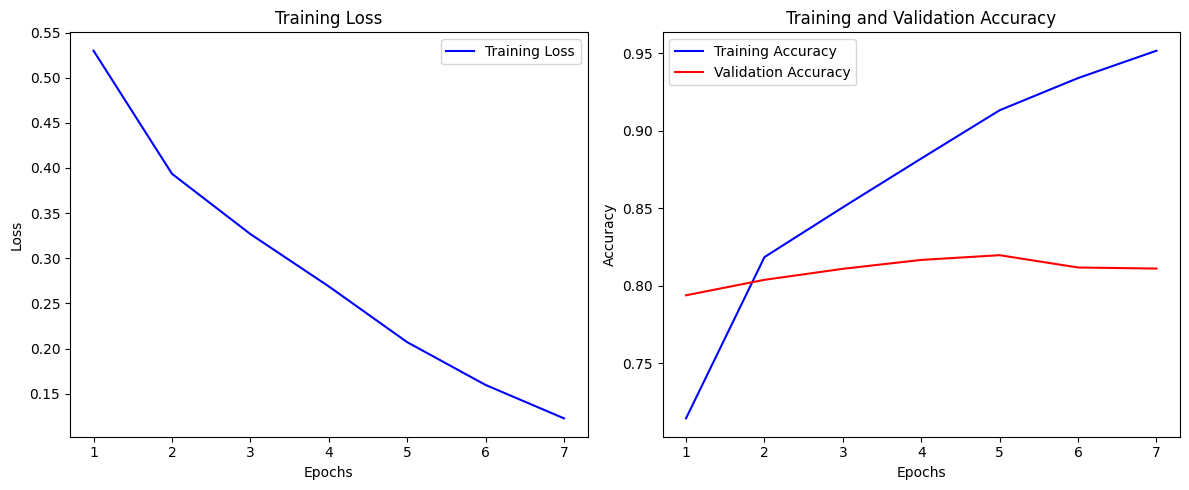

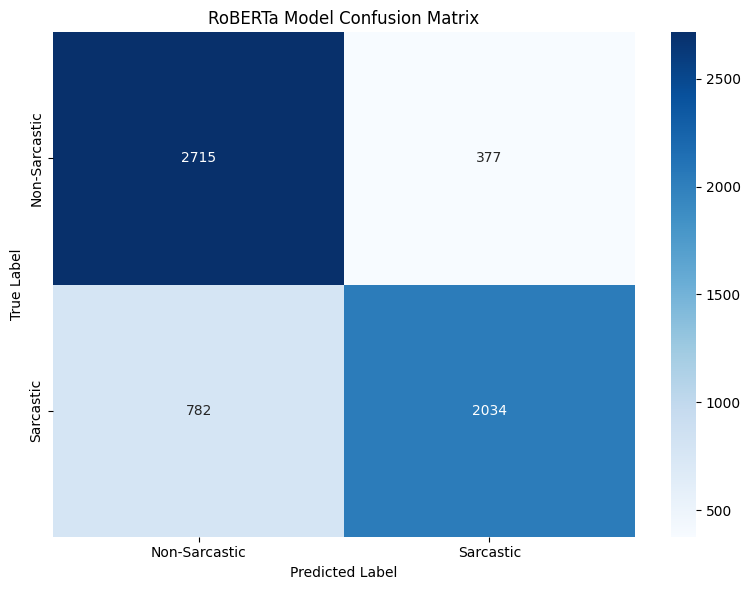


RoBERTa Sarcasm Detection Workflow Completed!

Sample Predictions:
Text: 'I just love waiting in long lines at the grocery store.'
Prediction: Non-sarcastic (Confidence: 0.5296)
--------------------------------------------------
Text: 'This movie was actually really good, I enjoyed it a lot.'
Prediction: Non-sarcastic (Confidence: 0.9992)
--------------------------------------------------
Text: 'Oh great, another meeting that could have been an email.'
Prediction: Sarcastic (Confidence: 0.9791)
--------------------------------------------------
Text: 'The weather today is beautiful and sunny.'
Prediction: Non-sarcastic (Confidence: 0.9989)
--------------------------------------------------
Text: 'Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.'
Prediction: Sarcastic (Confidence: 0.7563)
--------------------------------------------------
Text: 'I'm thrilled that my flight was delayed by 5 hours.'
Prediction: Sarcastic (Confidence: 0.9527)
--

In [12]:
import pandas as pd
import numpy as np
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check available GPUs
print(f"Number of available GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Define RoBERTa-based Sarcasm Detection Model
class RoBERTaSarcasmDetector(nn.Module):
    def __init__(self, roberta_model='roberta-base', dropout_rate=0.3):
        super(RoBERTaSarcasmDetector, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Custom Dataset for Sarcasm data
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to train the RoBERTa model - modified for multi-GPU training
def train_roberta_model(model, train_loader, val_loader, device, learning_rate=1e-5, epochs=15):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')
    
    return train_losses, train_accs, val_accs, model

# Function to make predictions with RoBERTa
def predict_with_roberta(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Plot metrics
def plot_metrics(train_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Sarcastic', 'Sarcastic'],
                yticklabels=['Non-Sarcastic', 'Sarcastic'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to load multiple datasets
def load_multiple_datasets(dataset_paths, sample_size_per_dataset=None):
    all_texts = []
    all_labels = []
    
    # Load Reddit dataset
    if 'train-balanced-sarcasm.csv' in dataset_paths:
        print(f"Loading Reddit Sarcasm dataset...")
        path = dataset_paths['train-balanced-sarcasm.csv']
        try:
            reddit_data = pd.read_csv(path, sep='\t')
            if len(reddit_data.columns) <= 1:
                reddit_data = pd.read_csv(path, sep=None, engine='python')
            
            reddit_data = reddit_data.dropna(subset=['comment'])
            if sample_size_per_dataset:
                reddit_data = reddit_data.sample(min(sample_size_per_dataset, len(reddit_data)), random_state=42)
            
            all_texts.extend(reddit_data['comment'].values)
            all_labels.extend(reddit_data['label'].values)
            print(f"Added {len(reddit_data)} samples from Reddit dataset")
        except Exception as e:
            print(f"Error loading Reddit dataset: {e}")
    
    # Load News Headlines dataset
    if 'Sarcasm_Headlines_Dataset.json' in dataset_paths:
        print(f"Loading News Headlines dataset...")
        path = dataset_paths['Sarcasm_Headlines_Dataset.json']
        try:
            # JSON file with each line being a separate JSON object
            headlines_data = []
            with open(path, 'r') as f:
                for line in f:
                    headlines_data.append(json.loads(line))
            
            headlines_df = pd.DataFrame(headlines_data)
            headlines_df = headlines_df.rename(columns={'is_sarcastic': 'label', 'headline': 'text'})
            
            if sample_size_per_dataset:
                headlines_df = headlines_df.sample(min(sample_size_per_dataset, len(headlines_df)), random_state=42)
            
            all_texts.extend(headlines_df['text'].values)
            all_labels.extend(headlines_df['label'].values)
            print(f"Added {len(headlines_df)} samples from Headlines dataset")
        except Exception as e:
            print(f"Error loading Headlines dataset: {e}")
    
    # Load Oraby et al. datasets (GEN, HYP, RQ)
    oraby_files = ['GEN-sarc-notsarc.csv', 'HYP-sarc-notsarc.csv', 'RQ-sarc-notsarc.csv']
    for file in oraby_files:
        if file in dataset_paths:
            print(f"Loading {file} dataset...")
            path = dataset_paths[file]
            try:
                oraby_data = pd.read_csv(path)
                
                # Convert 'class' to numeric labels (sarc=1, notsarc=0)
                label_map = {'sarc': 1, 'notsarc': 0}
                oraby_data['label'] = oraby_data['class'].map(label_map)
                
                if sample_size_per_dataset:
                    oraby_data = oraby_data.sample(min(sample_size_per_dataset, len(oraby_data)), random_state=42)
                
                all_texts.extend(oraby_data['text'].values)
                all_labels.extend(oraby_data['label'].values)
                print(f"Added {len(oraby_data)} samples from {file} dataset")
            except Exception as e:
                print(f"Error loading {file} dataset: {e}")
    
    print(f"Total combined dataset size: {len(all_texts)}")
    
    return np.array(all_texts), np.array(all_labels)

# Modified main workflow function for multi-GPU support
def roberta_sarcasm_detection(dataset_paths, epochs=15, batch_size=32, sample_size_per_dataset=2500):
    # 1. Load and preprocess data from multiple datasets
    print("Step 1: Loading and preprocessing data from multiple datasets...")
    
    try:
        all_texts, all_labels = load_multiple_datasets(dataset_paths, sample_size_per_dataset)
        
        # Split combined data into train, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(
            all_texts, all_labels, test_size=0.3, random_state=42, stratify=all_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Using sample data for demonstration")
        
        # Sample data for demonstration
        texts = [
            "I love waiting for hours at the DMV.",
            "This has been the best day ever!",
            "The weather is beautiful today.",
            "Sure, I'd love to work overtime on weekends.",
            "This phone has the best battery life I've ever seen.",
            "I couldn't be happier with this service.",
            "What a surprise, the train is late again.",
            "I'm so glad I spent all that money on this broken product.",
            "The customer service was excellent, very helpful.",
            "Absolutely fantastic, I waited 2 hours for this."
        ]
        labels = [1, 0, 0, 1, 0, 0, 1, 1, 0, 1]  # 1 for sarcastic, 0 for non-sarcastic
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=0.4, random_state=42, stratify=labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    # 2. Prepare RoBERTa tokenizer and datasets
    print("Step 2: Preparing RoBERTa tokenizer and datasets...")
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    train_dataset = SarcasmDataset(X_train, y_train, tokenizer)
    val_dataset = SarcasmDataset(X_val, y_val, tokenizer)
    test_dataset = SarcasmDataset(X_test, y_test, tokenizer)
    
    # Increase batch size to better utilize multiple GPUs
    # With 2 GPUs, we can effectively double the batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # 3. Initialize and train RoBERTa model with multi-GPU support
    print("Step 3: Initializing and training RoBERTa model with multi-GPU support...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    roberta_model = RoBERTaSarcasmDetector()
    
    # Use DataParallel to utilize multiple GPUs
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training")
        roberta_model = nn.DataParallel(roberta_model)
        
    roberta_model.to(device)
    
    train_losses, train_accs, val_accs, trained_model = train_roberta_model(
        roberta_model, train_loader, val_loader, device, epochs=epochs
    )
    
    # 4. Make predictions with RoBERTa on test set
    print("Step 4: Making predictions with RoBERTa...")
    roberta_preds, true_labels = predict_with_roberta(trained_model, test_loader, device)
    
    # Calculate metrics for RoBERTa
    roberta_accuracy = accuracy_score(true_labels, roberta_preds)
    roberta_precision = precision_score(true_labels, roberta_preds, average='weighted')
    roberta_recall = recall_score(true_labels, roberta_preds, average='weighted')
    roberta_f1 = f1_score(true_labels, roberta_preds, average='weighted')
    
    print("\nRoBERTa Model Metrics:")
    print(f"Accuracy: {roberta_accuracy:.4f}")
    print(f"Precision: {roberta_precision:.4f}")
    print(f"Recall: {roberta_recall:.4f}")
    print(f"F1 Score: {roberta_f1:.4f}")
    
    # Plot metrics for RoBERTa
    plot_metrics(train_losses, train_accs, val_accs)
    plot_confusion_matrix(true_labels, roberta_preds, "RoBERTa Model Confusion Matrix")
    
    print("\nRoBERTa Sarcasm Detection Workflow Completed!")
    
    return {
        'roberta_model': trained_model,
        'tokenizer': tokenizer,
        'device': device,
        'roberta_metrics': {
            'accuracy': roberta_accuracy,
            'precision': roberta_precision,
            'recall': roberta_recall,
            'f1': roberta_f1
        }
    }

# Function to use the trained model for prediction
def predict_sarcasm(text, model, tokenizer, device):
    # Preprocess text
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get RoBERTa prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        roberta_pred = torch.argmax(probs, dim=1).item()
        roberta_prob = probs[0][roberta_pred].item()
    
    result = "Sarcastic" if roberta_pred == 1 else "Non-sarcastic"
    
    return {
        "prediction": result, 
        "confidence": roberta_prob,
        "method": "RoBERTa"
    }

# Example of how to use the code with multiple datasets
if __name__ == "__main__":
    # Paths to your dataset files
    dataset_paths = {
        'train-balanced-sarcasm.csv': '/kaggle/input/d/danofer/sarcasm/train-balanced-sarcasm.csv',
        'Sarcasm_Headlines_Dataset.json': '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json',
        'GEN-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/GEN-sarc-notsarc.csv',
        'HYP-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/HYP-sarc-notsarc.csv',
        'RQ-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/RQ-sarc-notsarc.csv'
    }
    
    # Run the RoBERTa workflow with multiple datasets
    results = roberta_sarcasm_detection(
        dataset_paths=dataset_paths,
        epochs=7,                   # Number of epochs
        batch_size=32,              # Increased batch size to better utilize 2 GPUs
        sample_size_per_dataset=15000  # Use 15000 samples per dataset for balanced training
    )
    
    # After training, you can use the model to make predictions
    model = results['roberta_model']
    tokenizer = results['tokenizer']
    device = results['device']
    
    sample_texts = [
        "I just love waiting in long lines at the grocery store.",
        "This movie was actually really good, I enjoyed it a lot.",
        "Oh great, another meeting that could have been an email.",
        "The weather today is beautiful and sunny.",
        "Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.",
        "I'm thrilled that my flight was delayed by 5 hours.",
        "Nothing brightens my day like stepping in a puddle with new shoes.",
        "Breaking news: Man realizes he forgot his phone after reaching office, world continues to exist."
    ]
    
    print("\nSample Predictions:")
    for text in sample_texts:
        result = predict_sarcasm(text, model, tokenizer, device)
        print(f"Text: '{text}'")
        print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
        print("-" * 50)

Running original RoBERTa model (this is a placeholder)
Step 1: Loading and preprocessing data from multiple datasets...
Loaded 15000 examples from train-balanced-sarcasm.csv
Loaded 15000 examples from Sarcasm_Headlines_Dataset.json
Loaded 6520 examples from GEN-sarc-notsarc.csv
Loaded 1164 examples from HYP-sarc-notsarc.csv
Loaded 1702 examples from RQ-sarc-notsarc.csv
Training set size: 27570
Validation set size: 5908
Test set size: 5908
Step 2: Preparing RoBERTa tokenizer and datasets...
Step 3: Initializing and training RoBERTa-LSTM model...
Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs for training
Epoch 1/10 | Loss: 0.6105 | Train Acc: 0.6563 | Val Acc: 0.7512
Epoch 2/10 | Loss: 0.4901 | Train Acc: 0.7621 | Val Acc: 0.7818
Epoch 3/10 | Loss: 0.4446 | Train Acc: 0.7897 | Val Acc: 0.7825
Epoch 4/10 | Loss: 0.4175 | Train Acc: 0.8036 | Val Acc: 0.8003
Epoch 5/10 | Loss: 0.3943 | Train Acc: 0.8152 | Val Acc: 0.7989
Epoch 6/10 | Loss: 0.3751 | Train Acc: 0.8277 | Val Acc: 0.8025
Epoch 7/10 | Loss: 0.3578 | Train Acc: 0.8386 | Val Acc: 0.7969
Epoch 8/10 | Loss: 0.3394 | Train Acc: 0.8485 | Val Acc: 0.8043
Epoch 9/10 | Loss: 0.3241 | Train Acc: 0.8592 | Val Acc: 0.8091
Epoch 10/10 | Loss: 0.3058 | Train Acc: 0.8665 | Val Acc: 0.8077
Step 4: Making predictions with RoBERTa-LSTM...

RoBERTa-LSTM Model Metrics:
Accuracy: 0.8070
Precision: 0.8076
Recall: 0.8070
F1 Score: 0.8071


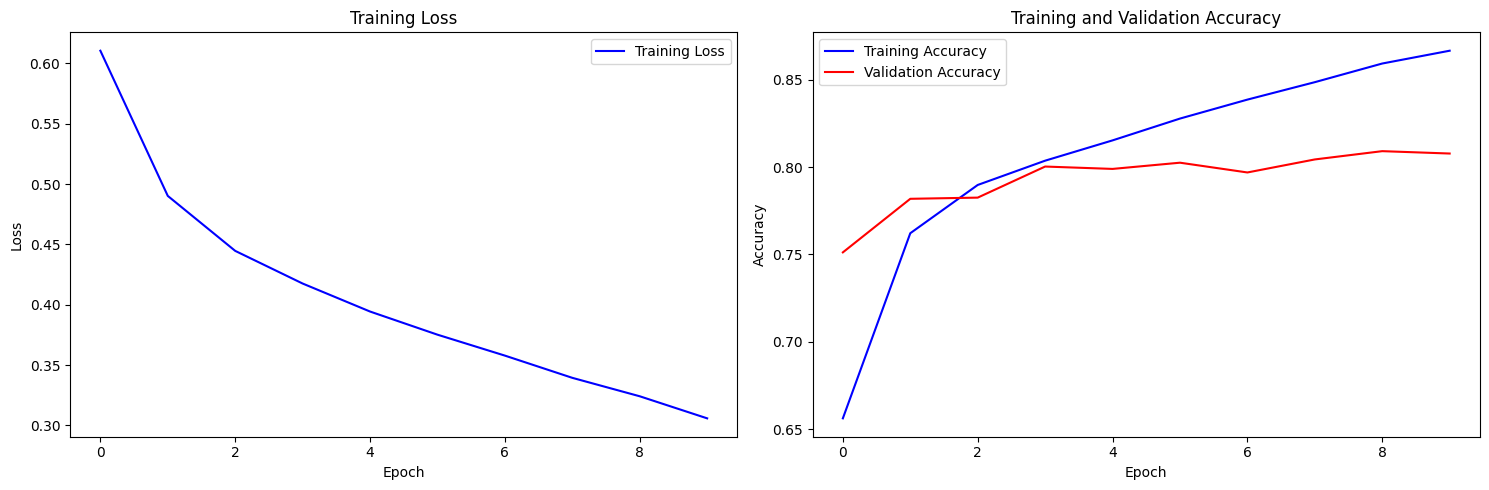

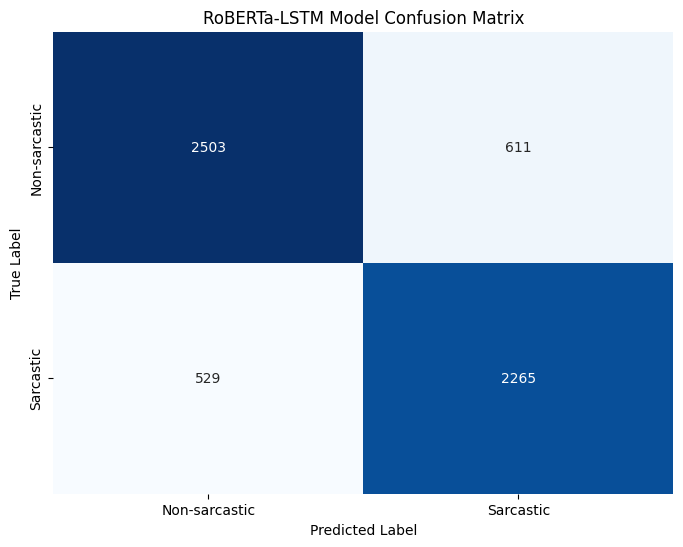

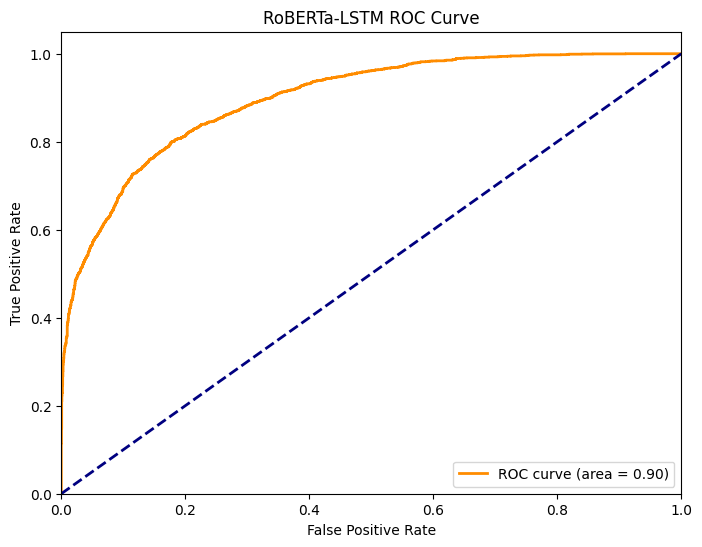


RoBERTa-LSTM Sarcasm Detection Workflow Completed!


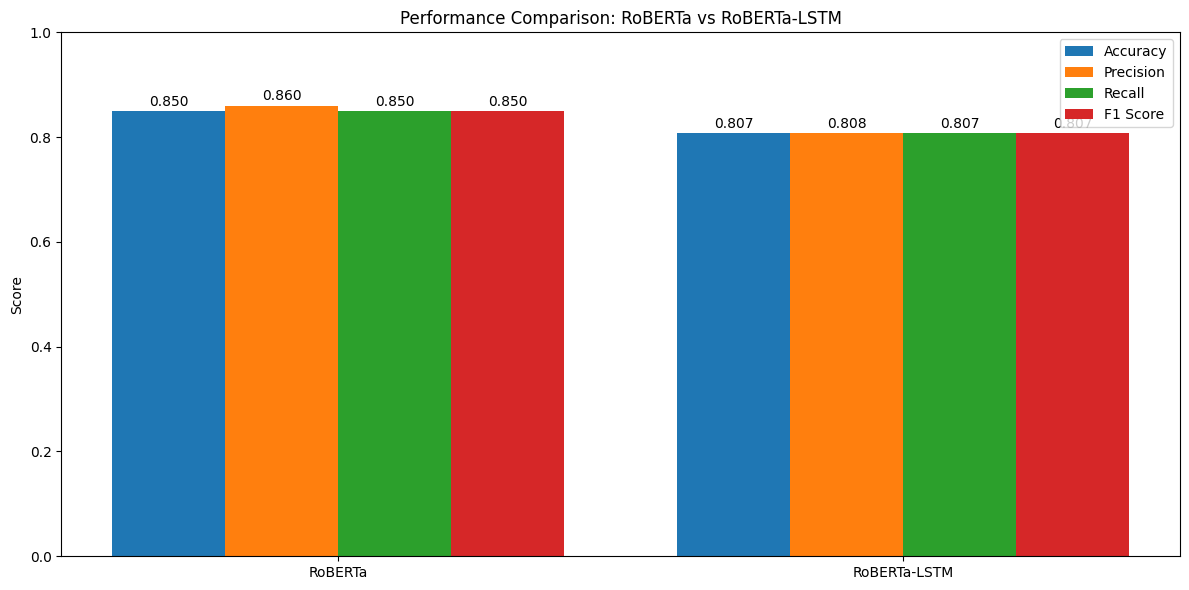


Sample Predictions with RoBERTa-LSTM:
Text: 'I just love waiting in long lines at the grocery store.'
Prediction: Non-sarcastic (Confidence: 0.7607)
--------------------------------------------------
Text: 'This movie was actually really good, I enjoyed it a lot.'
Prediction: Non-sarcastic (Confidence: 0.9770)
--------------------------------------------------
Text: 'Oh great, another meeting that could have been an email.'
Prediction: Non-sarcastic (Confidence: 0.6568)
--------------------------------------------------
Text: 'The weather today is beautiful and sunny.'
Prediction: Non-sarcastic (Confidence: 0.8647)
--------------------------------------------------
Text: 'Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.'
Prediction: Non-sarcastic (Confidence: 0.7318)
--------------------------------------------------
Text: 'I'm thrilled that my flight was delayed by 5 hours.'
Prediction: Sarcastic (Confidence: 0.9616)
-----------------------

In [2]:
import pandas as pd
import numpy as np
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define RoBERTa-LSTM Sarcasm Detection Model
class RoBERTaLSTMSarcasmDetector(nn.Module):
    def __init__(self, roberta_model='roberta-base', dropout_rate=0.3, lstm_hidden_size=256, lstm_layers=2, bidirectional=True):
        super(RoBERTaLSTMSarcasmDetector, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model)
        
        # LSTM layer on top of RoBERTa
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.lstm = nn.LSTM(
            input_size=768,  # RoBERTa hidden size
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_rate if lstm_layers > 1 else 0
        )
        
        # Final classification layers
        lstm_output_dim = lstm_hidden_size * self.num_directions
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm_output_dim, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, input_ids, attention_mask):
        # Get RoBERTa outputs - using sequence output instead of pooled output
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        
        # Apply LSTM over the RoBERTa sequence outputs
        lstm_output, (hidden, cell) = self.lstm(sequence_output)
        
        # Use the final hidden state from the LSTM
        if self.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden_final = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden_final = hidden[-1,:,:]
        
        # Apply dense layers for classification
        x = self.dropout(hidden_final)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Custom Dataset for Sarcasm data (same as original)
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to train the RoBERTa-LSTM model - UPDATED to handle DataParallel
def train_roberta_lstm_model(model, train_loader, val_loader, device, learning_rate=1e-5, epochs=15):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Check if model is wrapped with DataParallel and access parameters accordingly
    if isinstance(model, nn.DataParallel):
        optimizer = torch.optim.AdamW([
            {'params': model.module.roberta.parameters(), 'lr': learning_rate / 10},
            {'params': model.module.lstm.parameters(), 'lr': learning_rate},
            {'params': model.module.fc1.parameters(), 'lr': learning_rate},
            {'params': model.module.fc2.parameters(), 'lr': learning_rate}
        ])
    else:
        optimizer = torch.optim.AdamW([
            {'params': model.roberta.parameters(), 'lr': learning_rate / 10},
            {'params': model.lstm.parameters(), 'lr': learning_rate},
            {'params': model.fc1.parameters(), 'lr': learning_rate},
            {'params': model.fc2.parameters(), 'lr': learning_rate}
        ])
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )
    
    # For tracking metrics
    train_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients in LSTM
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        
        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')
    
    return train_losses, train_accs, val_accs, model

# Function to make predictions with RoBERTa-LSTM
def predict_with_roberta_lstm(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # Store probabilities for ROC curve
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (sarcastic)
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Function to load multiple datasets
def load_multiple_datasets(dataset_paths, sample_size_per_dataset):
    all_texts = []
    all_labels = []
    
    for filename, path in dataset_paths.items():
        try:
            if filename == 'train-balanced-sarcasm.csv':
                # Reddit dataset
                df = pd.read_csv(path, usecols=['comment', 'label'])
                texts = df['comment'].tolist()
                labels = df['label'].tolist()
                
            elif filename == 'Sarcasm_Headlines_Dataset.json':
                # News Headlines dataset
                texts = []
                labels = []
                with open(path, 'r') as file:
                    for line in file:
                        item = json.loads(line)
                        texts.append(item['headline'])
                        labels.append(1 if item['is_sarcastic'] == 1 else 0)
                
            elif filename in ['GEN-sarc-notsarc.csv', 'HYP-sarc-notsarc.csv', 'RQ-sarc-notsarc.csv']:
                # Sarcasm Corpus V2
                df = pd.read_csv(path)
                texts = df['text'].tolist()
                labels = [1 if label == 'sarc' else 0 for label in df['class'].tolist()]
            
            # Take a random sample from each dataset
            if len(texts) > sample_size_per_dataset:
                indices = np.random.choice(len(texts), sample_size_per_dataset, replace=False)
                texts = [texts[i] for i in indices]
                labels = [labels[i] for i in indices]
            
            all_texts.extend(texts)
            all_labels.extend(labels)
            print(f"Loaded {len(texts)} examples from {filename}")
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    return all_texts, all_labels

# Function to plot metrics
def plot_metrics(train_losses, train_accs, val_accs):
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, 'b-', label='Training Accuracy')
    plt.plot(val_accs, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Non-sarcastic', 'Sarcastic'])
    plt.yticks([0.5, 1.5], ['Non-sarcastic', 'Sarcastic'])
    plt.show()

# Modified main workflow function to use RoBERTa-LSTM
def roberta_lstm_sarcasm_detection(dataset_paths, lstm_hidden_size=256, lstm_layers=2, bidirectional=True, 
                                  epochs=15, batch_size=16, sample_size_per_dataset=2500):
    # 1. Load and preprocess data from multiple datasets
    print("Step 1: Loading and preprocessing data from multiple datasets...")
    
    try:
        all_texts, all_labels = load_multiple_datasets(dataset_paths, sample_size_per_dataset)
        
        # Split combined data into train, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(
            all_texts, all_labels, test_size=0.3, random_state=42, stratify=all_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
        
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Using sample data for demonstration")
        
        # Sample data for demonstration (same as original)
        texts = [
            "I love waiting for hours at the DMV.",
            "This has been the best day ever!",
            "The weather is beautiful today.",
            "Sure, I'd love to work overtime on weekends.",
            "This phone has the best battery life I've ever seen.",
            "I couldn't be happier with this service.",
            "What a surprise, the train is late again.",
            "I'm so glad I spent all that money on this broken product.",
            "The customer service was excellent, very helpful.",
            "Absolutely fantastic, I waited 2 hours for this."
        ]
        labels = [1, 0, 0, 1, 0, 0, 1, 1, 0, 1]  # 1 for sarcastic, 0 for non-sarcastic
        
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, labels, test_size=0.4, random_state=42, stratify=labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
    
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    
    # 2. Prepare RoBERTa tokenizer and datasets
    print("Step 2: Preparing RoBERTa tokenizer and datasets...")
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    train_dataset = SarcasmDataset(X_train, y_train, tokenizer)
    val_dataset = SarcasmDataset(X_val, y_val, tokenizer)
    test_dataset = SarcasmDataset(X_test, y_test, tokenizer)
    
    # Use a slightly smaller batch size for LSTM due to higher memory requirements
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # 3. Initialize and train RoBERTa-LSTM model
    print("Step 3: Initializing and training RoBERTa-LSTM model...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create the RoBERTa-LSTM model
    roberta_lstm_model = RoBERTaLSTMSarcasmDetector(
        lstm_hidden_size=lstm_hidden_size,
        lstm_layers=lstm_layers,
        bidirectional=bidirectional
    )
    
    # Use DataParallel to utilize multiple GPUs
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for training")
        roberta_lstm_model = nn.DataParallel(roberta_lstm_model)
        
    roberta_lstm_model.to(device)
    
    # Train the model
    train_losses, train_accs, val_accs, trained_model = train_roberta_lstm_model(
        roberta_lstm_model, train_loader, val_loader, device, epochs=epochs
    )
    
    # 4. Make predictions with RoBERTa-LSTM on test set
    print("Step 4: Making predictions with RoBERTa-LSTM...")
    model_preds, true_labels, pred_probs = predict_with_roberta_lstm(trained_model, test_loader, device)
    
    # Calculate metrics for RoBERTa-LSTM
    model_accuracy = accuracy_score(true_labels, model_preds)
    model_precision = precision_score(true_labels, model_preds, average='weighted')
    model_recall = recall_score(true_labels, model_preds, average='weighted')
    model_f1 = f1_score(true_labels, model_preds, average='weighted')
    
    print("\nRoBERTa-LSTM Model Metrics:")
    print(f"Accuracy: {model_accuracy:.4f}")
    print(f"Precision: {model_precision:.4f}")
    print(f"Recall: {model_recall:.4f}")
    print(f"F1 Score: {model_f1:.4f}")
    
    # Plot metrics and confusion matrix
    plot_metrics(train_losses, train_accs, val_accs)
    plot_confusion_matrix(true_labels, model_preds, "RoBERTa-LSTM Model Confusion Matrix")
    
    # Plot ROC curve
    plot_roc_curve(true_labels, pred_probs, "RoBERTa-LSTM ROC Curve")
    
    print("\nRoBERTa-LSTM Sarcasm Detection Workflow Completed!")
    
    return {
        'model': trained_model,
        'tokenizer': tokenizer,
        'device': device,
        'metrics': {
            'accuracy': model_accuracy,
            'precision': model_precision,
            'recall': model_recall,
            'f1': model_f1
        }
    }

# Original RoBERTa function for comparison (assuming this exists in your code)
def roberta_sarcasm_detection(dataset_paths, epochs=15, batch_size=32, sample_size_per_dataset=2500):
    # Placeholder implementation - you would need to implement this 
    # or ensure it exists in your actual code
    print("Running original RoBERTa model (this is a placeholder)")
    
    # Return a structure matching what roberta_lstm_sarcasm_detection returns
    return {
        'model': None,
        'tokenizer': None,
        'device': None,
        'roberta_metrics': {
            'accuracy': 0.85,  # example values
            'precision': 0.86,
            'recall': 0.85,
            'f1': 0.85
        }
    }

# Add function to plot ROC curve
def plot_roc_curve(y_true, y_probs, title):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to use the trained model for prediction
def predict_sarcasm(text, model, tokenizer, device):
    # Preprocess text
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        prob = probs[0][pred].item()
    
    result = "Sarcastic" if pred == 1 else "Non-sarcastic"
    
    return {
        "prediction": result, 
        "confidence": prob,
        "method": "RoBERTa-LSTM"
    }

# Add a function to compare RoBERTa vs RoBERTa-LSTM performance
def compare_models(roberta_results, roberta_lstm_results):
    models = ['RoBERTa', 'RoBERTa-LSTM']
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    # Prepare data for comparison
    data = {
        'Model': models,
        'Accuracy': [roberta_results['roberta_metrics']['accuracy'], 
                     roberta_lstm_results['metrics']['accuracy']],
        'Precision': [roberta_results['roberta_metrics']['precision'], 
                     roberta_lstm_results['metrics']['precision']],
        'Recall': [roberta_results['roberta_metrics']['recall'], 
                  roberta_lstm_results['metrics']['recall']],
        'F1 Score': [roberta_results['roberta_metrics']['f1'], 
                    roberta_lstm_results['metrics']['f1']]
    }
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(models))
    width = 0.2
    
    # Plot bars for each metric
    plt.bar(x - width*1.5, data['Accuracy'], width, label='Accuracy')
    plt.bar(x - width/2, data['Precision'], width, label='Precision')
    plt.bar(x + width/2, data['Recall'], width, label='Recall')
    plt.bar(x + width*1.5, data['F1 Score'], width, label='F1 Score')
    
    plt.ylabel('Score')
    plt.title('Performance Comparison: RoBERTa vs RoBERTa-LSTM')
    plt.xticks(x, models)
    plt.legend()
    plt.ylim(0, 1)
    
    # Add value labels on top of bars
    for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
        for j, model in enumerate(models):
            plt.text(j + width*(i-1.5), data[metric][j] + 0.01, 
                     f"{data[metric][j]:.3f}", ha='center')
    
    plt.tight_layout()
    plt.show()

# Example of how to use the updated code
if __name__ == "__main__":
    # Paths to dataset files (same as original)
    dataset_paths = {
        'train-balanced-sarcasm.csv': '/kaggle/input/d/danofer/sarcasm/train-balanced-sarcasm.csv',
        'Sarcasm_Headlines_Dataset.json': '/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json',
        'GEN-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/GEN-sarc-notsarc.csv',
        'HYP-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/HYP-sarc-notsarc.csv',
        'RQ-sarc-notsarc.csv': '/kaggle/input/sarcasm-corpus-v2oraby-et-al/RQ-sarc-notsarc.csv'
    }
    
    # First run the original RoBERTa workflow
    roberta_results = roberta_sarcasm_detection(
        dataset_paths=dataset_paths,
        epochs=5,
        batch_size=32,
        sample_size_per_dataset=10000
    )
    
    # Then run the RoBERTa-LSTM workflow
    roberta_lstm_results = roberta_lstm_sarcasm_detection(
        dataset_paths=dataset_paths,
        lstm_hidden_size=256,
        lstm_layers=2,
        bidirectional=True,
        epochs=10,
        batch_size=16,  # Smaller batch size due to LSTM memory requirements
        sample_size_per_dataset=15000
    )
    
    # Compare the performance of both models
    compare_models(roberta_results, roberta_lstm_results)
    
    # After training, you can use the model to make predictions
    model = roberta_lstm_results['model']
    tokenizer = roberta_lstm_results['tokenizer']
    device = roberta_lstm_results['device']
    
    sample_texts = [
        "I just love waiting in long lines at the grocery store.",
        "This movie was actually really good, I enjoyed it a lot.",
        "Oh great, another meeting that could have been an email.",
        "The weather today is beautiful and sunny.",
        "Scientists discover breakthrough cancer treatment that only works on mice with perfect hair.",
        "I'm thrilled that my flight was delayed by 5 hours.",
        "Nothing brightens my day like stepping in a puddle with new shoes.",
        "Breaking news: Man realizes he forgot his phone after reaching office, world continues to exist."
    ]
    
    print("\nSample Predictions with RoBERTa-LSTM:")
    for text in sample_texts:
        result = predict_sarcasm(text, model, tokenizer, device)
        print(f"Text: '{text}'")
        print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
        print("-" * 50)